# VCF QC & Summary

In [1]:
# Import packages.
import allel
import numcodecs
import zarr
from functools import reduce
import gzip
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import math

## QC

In [2]:
# Read in meta data has a pandas dataframe.
meta_df = pd.read_csv(
    './matute_meta_data.txt',
    sep='\t',
    names=['strain', 'population'],
)
# Extract the strains.
strain_array = meta_df['strain'].values
# Intialize a dictionary.
idx_dicc = {}
# For all populations.
for pop in ['san', 'yak_symp', 'yak_allo', 'tei']:
    # Fill the dictionary.
    idx_dicc[pop] = meta_df[meta_df['population'] == pop].index.values
meta_df

,strain,population
0,BS14,san
1,C550_39,san
2,C650_14,san
3,CAR1600,san
4,Qiuja630.39,san
...,...,...
61,Bata2,tei
62,Bata8,tei
63,La_Lope_Gabon,tei
64,Selinda,tei


In [3]:
# Define a function to load and extract information from a vcf file.
def load_prefiltered_data(prefix):
    # Intialize a path.
    path = f'../zarrs/{prefix}/san_yak_tei_prefiltered.zarr'
    # Load the vcf file.
    callset = zarr.open_group(path, mode='r')
    # Intialize a dictionary.
    vcf_dicc = {}
    # Extract the samples.
    vcf_dicc['SAMPS'] = callset['samples']
    # Extract the positions.
    vcf_dicc['POS'] = callset['variants/POS']
    # Extract the chromosomes.
    vcf_dicc['CHROM'] = callset['variants/CHROM']
    # Extract read depth.
    vcf_dicc['DP'] = callset['variants/DP']
    # Extract the genotypes.
    vcf_dicc['GT'] = allel.GenotypeArray(callset['calldata/GT'])
    return vcf_dicc

In [4]:
# Load the data mapped to the san reference.
san_dicc = load_prefiltered_data('san')
# Load the data mapped to the yak reference.
yak_dicc = load_prefiltered_data('yak')

In [5]:
# See if the samples are in the same order.
print(
    'it is {0} that the san samples are in the same order'.format(np.array_equal(strain_array, san_dicc['SAMPS'])),
)
print(
    'it is {0} that the yak samples are in the same order'.format(np.array_equal(strain_array, yak_dicc['SAMPS'])),
)

it is True that the san samples are in the same order
it is True that the yak samples are in the same order


In [6]:
# Inspect the unfiltered san data.
san_dicc['GT']

<GenotypeArray shape=(5547463, 66, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 ./. 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 ./. 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 ./. 0/0 0/0 0/0
...
0/0 0/0 ./. 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 ./. 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 ./. 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [7]:
# Inspect the unfiltered yak data.
yak_dicc['GT']

<GenotypeArray shape=(5792568, 66, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

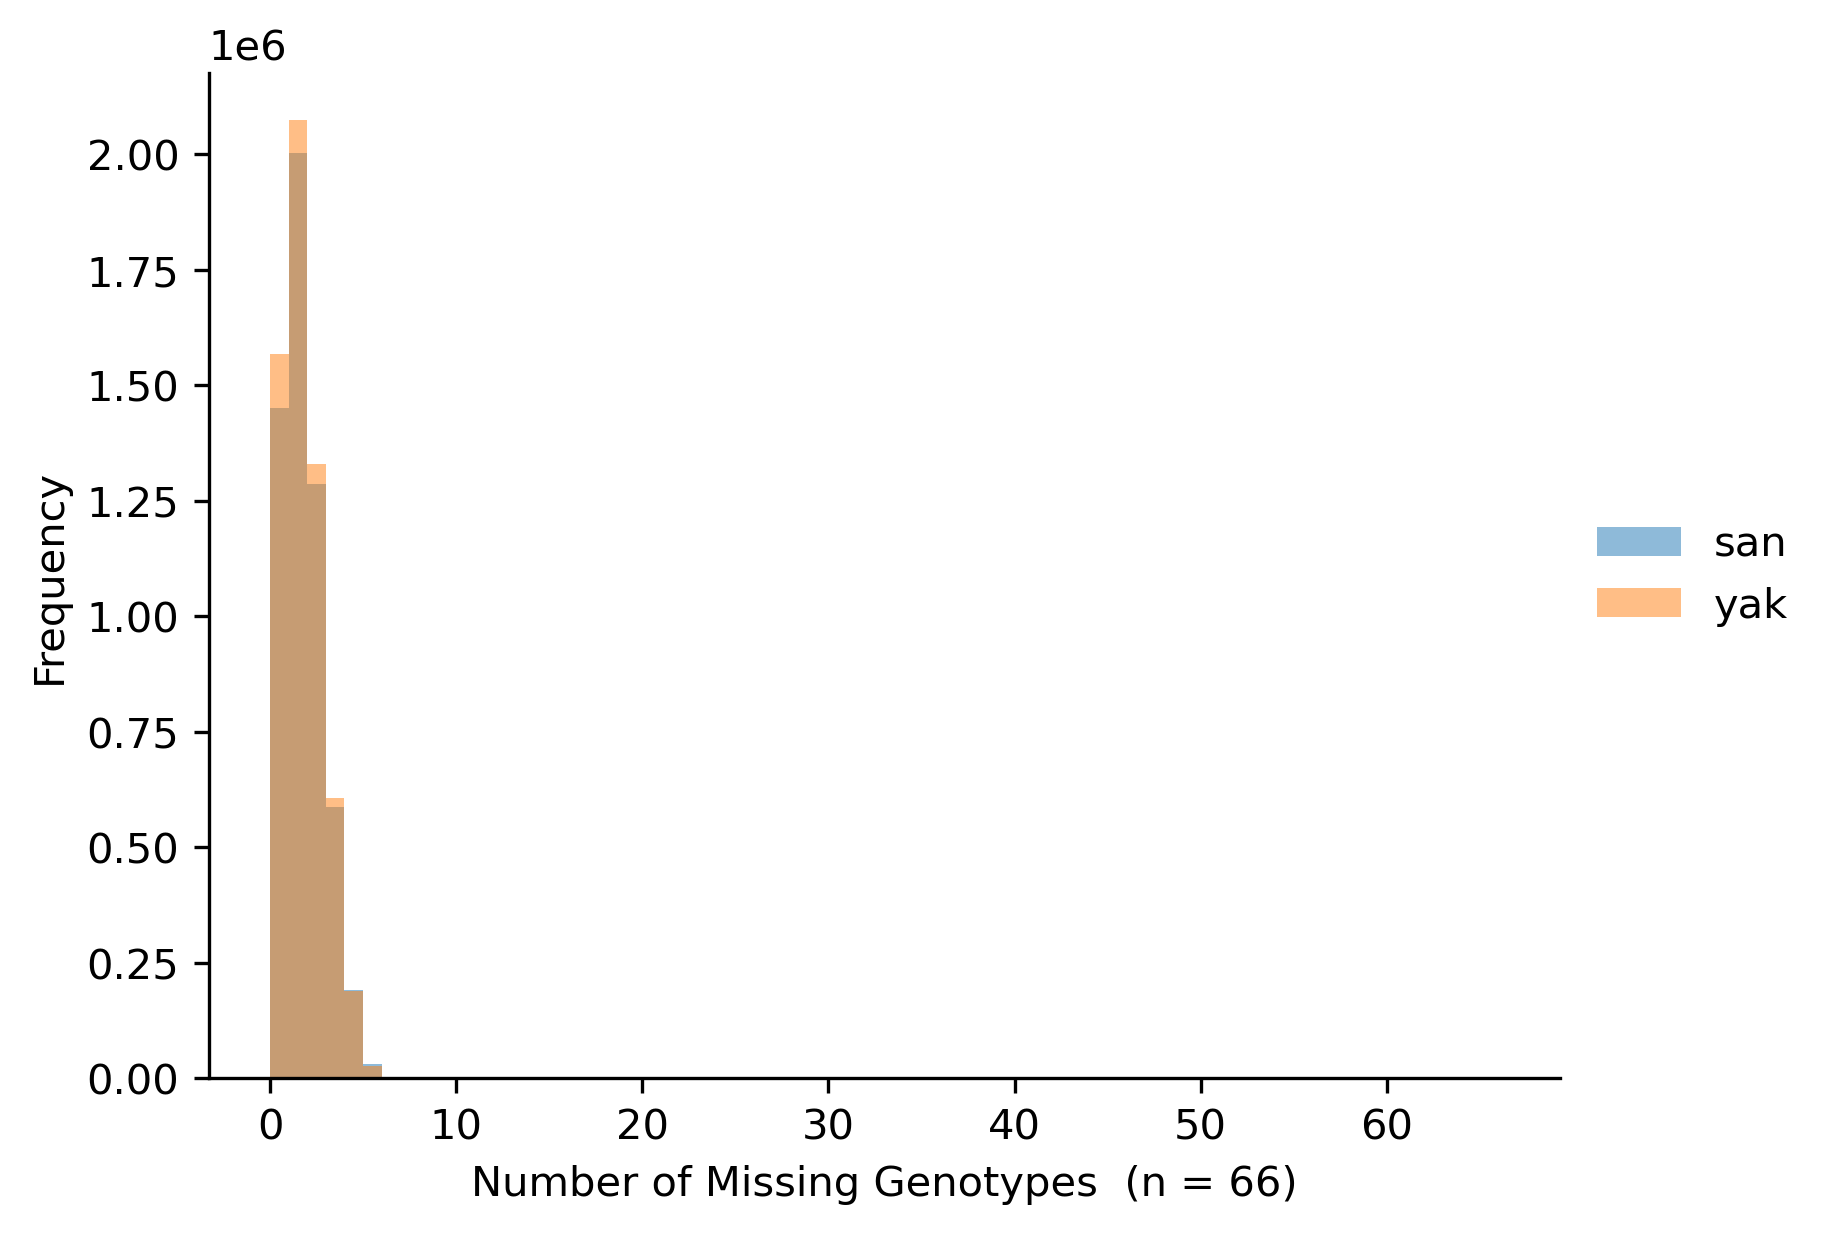

In [8]:
# Plot the distribution of total number of missing samples per site.
# Intialize the figure.
fig = plt.figure(figsize=(6, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot a histogram of missing data.
ax.hist(
    san_dicc['GT'].count_missing(axis=1), bins=np.arange(0, 67),
    histtype='stepfilled', alpha=0.5, color='tab:blue', label='san',
)
ax.hist(
    yak_dicc['GT'].count_missing(axis=1), bins=np.arange(0, 67),
    histtype='stepfilled', alpha=0.5,  color='tab:orange', label='yak',
)
# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Intialize the legend.
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
# Label the axes.
plt.xlabel('Number of Missing Genotypes  (n = 66)')
plt.ylabel('Frequency')
# Show!
plt.show()

In [9]:
# Intialize dictionaries.
san_pop_dicc = {}
yak_pop_dicc = {}
# For every population.
for key in idx_dicc.keys():
    # Intialize the dictionary.
    san_pop_dicc[key] = {}
    yak_pop_dicc[key] = {}
    # Fill the dictionaries.
    san_pop_dicc[key]['GT'] = san_dicc['GT'].take(idx_dicc[key], axis=1)
    yak_pop_dicc[key]['GT'] = yak_dicc['GT'].take(idx_dicc[key], axis=1)

In [10]:
# For every population.
for pop in ['san', 'yak_symp', 'yak_allo', 'tei']:
    # Determine the sites with 90% of samples called.
    san_pop_dicc[pop]['C_IDX'] = np.where(
        san_pop_dicc[pop]['GT'].count_called(axis=1) >= (san_pop_dicc[pop]['GT'].shape[1] * 0.9),
    )[0]
    yak_pop_dicc[pop]['C_IDX'] = np.where(
        yak_pop_dicc[pop]['GT'].count_called(axis=1) >= (yak_pop_dicc[pop]['GT'].shape[1] * 0.9),
    )[0]

In [11]:
# Determine the indicies where all samples are called.
san_all_call_idx = reduce(
    np.intersect1d,(
        san_pop_dicc['san']['C_IDX'], san_pop_dicc['yak_symp']['C_IDX'],
        san_pop_dicc['yak_allo']['C_IDX'], san_pop_dicc['tei']['C_IDX'],
    ),
)
yak_all_call_idx = reduce(
    np.intersect1d,(
        yak_pop_dicc['san']['C_IDX'], yak_pop_dicc['yak_symp']['C_IDX'],
        yak_pop_dicc['yak_allo']['C_IDX'], yak_pop_dicc['tei']['C_IDX'],
    ),
)

In [12]:
# Build data frame dictionaries.
san_filter_dicc = {
    'CHROM': san_dicc['CHROM'][san_all_call_idx],
    'POS': san_dicc['POS'][san_all_call_idx],
}
yak_filter_dicc = {
    'CHROM': yak_dicc['CHROM'][yak_all_call_idx],
    'POS': yak_dicc['POS'][yak_all_call_idx],
}
# Intialize data frames.
san_filter_df = pd.DataFrame(data=san_filter_dicc)
yak_filter_df = pd.DataFrame(data=yak_filter_dicc)
# Export the files filtering.
# san_filter_df.to_csv('../vcfs/san_qc_passed_sites.txt', sep='\t', header=False, index=False)
# yak_filter_df.to_csv('../vcfs/yak_qc_passed_sites.txt', sep='\t', header=False, index=False)

In [13]:
# # For every chromosome...
# for chrom in ['2L', '2R', '3L', '3R', '4', 'X']:
#     # Export the individual chromosome mapping.
#     san_chrom_df = san_filter_df[san_filter_df['CHROM'] == chrom]
#     yak_chrom_df = yak_filter_df[yak_filter_df['CHROM'] == chrom]
#     san_chrom_df.to_csv(f'../vcfs/san_qc_passed_sites_chr{chrom}.txt', sep='\t', header=False, index=False)
#     yak_chrom_df.to_csv(f'../vcfs/yak_qc_passed_sites_chr{chrom}.txt', sep='\t', header=False, index=False)

## Identifying Positions of 1:1 Orthologs

In [14]:
# Read in the san gff file.
san_gff_df = pd.read_csv(
    '../annotations/Dsan.genomic.gff.gz', sep='\t', skiprows=8, skipfooter=1,
    names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'],
)
# Read in the yak gff file.
yak_gff_df = pd.read_csv(
    '../annotations/Dyak.genomic.gff.gz', sep='\t', skiprows=8, skipfooter=1,
    names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'],
)

/tmp/ipykernel_120845/4209385292.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  san_gff_df = pd.read_csv(
/tmp/ipykernel_120845/4209385292.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  yak_gff_df = pd.read_csv(


In [15]:
# Filter everything, but genes.
san_gene_gff_df = san_gff_df[(san_gff_df['type'] == 'gene') & (san_gff_df['source'] == 'Gnomon')].reset_index(drop=True)
yak_gene_gff_df = yak_gff_df[(yak_gff_df['type'] == 'gene') & (yak_gff_df['source'] == 'Gnomon')].reset_index(drop=True)

In [16]:
# Define a function to extract gene ids.
def find_gene(x):
    # Define the pattern.
    pattern = re.compile(r'gene=([^;]*)')
    # Serach for the match.
    match = pattern.search(x)
    return match.group(1)

In [17]:
# Create a new column with the gene id information.
san_gene_gff_df['gene_id'] = san_gene_gff_df['attributes'].apply(find_gene)
yak_gene_gff_df['gene_id'] = yak_gene_gff_df['attributes'].apply(find_gene)

In [18]:
# Load the 1:1 ortholog data.
ortholog_df = pd.read_csv(
    '../annotations/orthogroup_mel_san_yak_mapping.txt',
    sep='\t', names=['orthogroup', 'mel', 'san', 'yak'],
)
ortholog_df

,orthogroup,mel,san,yak
0,OG0000947,CG17636,LOC120446823,LOC6531910
1,OG0000948,RhoGAP1A,LOC120455198,LOC6526243
2,OG0000949,CG17707,LOC120455199,LOC6523777
3,OG0000950,tyn,LOC120455200,LOC6523778
4,OG0000951,CG3038,LOC120455201,LOC6523779
...,...,...,...,...
11838,OG0012796,PIP4K,LOC120454840,LOC6523772
11839,OG0012797,Mitf,LOC120454834,LOC6523773
11840,OG0012798,Dyrk3,LOC120454870,LOC6523774
11841,OG0012799,Cadps,LOC120454845,LOC6523775


In [19]:
# Extact the ortholog data.
mel_orthologs = ortholog_df['mel'].values
san_orthologs = ortholog_df['san'].values
yak_orthologs = ortholog_df['yak'].values
# Extract the gene id data.
san_genes = san_gene_gff_df['gene_id'].values
yak_genes = yak_gene_gff_df['gene_id'].values

In [20]:
# Create gene masks.
san_mask = np.isin(san_genes, san_orthologs)
yak_mask = np.isin(yak_genes, yak_orthologs)

In [21]:
# Create masked data frames to only include the 1:1 orthologs.
san_ortholog_df = san_gene_gff_df[san_mask]
yak_ortholog_df = yak_gene_gff_df[yak_mask]

In [22]:
# Construct dictionaries to rename the seqids.
san_chrom_map_dicc = {
    'NC_053016.2': '2L', 'NC_053017.2': '2R',
    'NC_053018.2': '3L', 'NC_053019.2': '3R',
    'NC_053020.2': '4', 'NC_053021.2': 'X',
    'NW_025318933.1': 'UM', 'NW_025318934.1': 'UM',
    'NW_025318945.1': 'UM', 'NW_025318991.1': 'UM',
    'NW_025318995.1': 'UM', 'NW_025319002.1': 'UM',
    'NW_025319012.1': 'UM', 'NW_025319013.1': 'UM',
    'NW_025319019.1': 'UM', 'NW_025319021.1': 'UM',
}
yak_chrom_map_dicc = {
    'NC_052527.2': '2L', 'NC_052528.2': '2R',
    'NC_052529.2': '3L', 'NC_052530.2': '3R',
    'NC_052531.2': '4', 'NC_052526.2': 'X',
    'NW_025048783.1': 'UM', 'NW_025048801.1': 'UM',
    'NW_025048817.1': 'UM', 'NW_025048824.1': 'UM',
}

In [23]:
# Create a chromosome column.
san_ortholog_df['chr'] = san_ortholog_df['seqid'].map(san_chrom_map_dicc)
yak_ortholog_df['chr'] = yak_ortholog_df['seqid'].map(yak_chrom_map_dicc)

/tmp/ipykernel_120845/3319307266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  san_ortholog_df['chr'] = san_ortholog_df['seqid'].map(san_chrom_map_dicc)
/tmp/ipykernel_120845/3319307266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yak_ortholog_df['chr'] = yak_ortholog_df['seqid'].map(yak_chrom_map_dicc)


In [24]:
# Remove all unmapped chromosomes.
san_ortholog_cleaned_df = san_ortholog_df[san_ortholog_df['chr'] != 'UM']
yak_ortholog_cleaned_df = yak_ortholog_df[yak_ortholog_df['chr'] != 'UM']
# Create the dataframes.
san_ortholog_coord_df = san_ortholog_cleaned_df.loc[:, ['gene_id', 'chr', 'start', 'end']].reset_index(drop=True)
yak_ortholog_coord_df = yak_ortholog_cleaned_df.loc[:, ['gene_id', 'chr', 'start', 'end']].reset_index(drop=True)
# Change the start and end positions to integers.
san_ortholog_coord_df['start'] = san_ortholog_coord_df['start'].astype(int)
san_ortholog_coord_df['end'] = san_ortholog_coord_df['end'].astype(int)
yak_ortholog_coord_df['start'] = yak_ortholog_coord_df['start'].astype(int)
yak_ortholog_coord_df['end'] = yak_ortholog_coord_df['end'].astype(int)
# Export ortholog coordinate files.
# san_ortholog_coord_df.to_csv('../annotations/san_ortholog_coords.txt', sep='\t', header=False, index=False)
# yak_ortholog_coord_df.to_csv('../annotations/yak_ortholog_coords.txt', sep='\t', header=False, index=False)

In [25]:
# Determine the length of each gene.
san_ortholog_coord_df['length'] = san_ortholog_coord_df['end'] - san_ortholog_coord_df['start']
yak_ortholog_coord_df['length'] = yak_ortholog_coord_df['end'] - yak_ortholog_coord_df['start']

In [26]:
# Construct chromosome length dictionaries.
san_chrom_len_dicc = {
    '2L': 27915280, '2R': 22646313,
    '3L': 25621868, '3R': 29038104,
    '4': 1429326, 'X': 22631256,
}
yak_chrom_len_dicc = {
    '2L': 31052931, '2R': 23815334,
    '3L': 25180761, '3R': 30730773,
    '4': 1429802, 'X': 24674056,
}

In [27]:
# Intialize lists for adjusted starts and ends.
san_adj_start = []
san_adj_end = []
# For all chromosomes.
for chrom in san_ortholog_coord_df['chr'].unique():
    # Subset the dataframe.
    chrom_df = san_ortholog_coord_df[san_ortholog_coord_df['chr'] == chrom]
    # Extract the starts, ends, and lengths.
    starts = chrom_df['start'].values
    ends = chrom_df['end'].values
    lengths = chrom_df['length'].values
    # For every gene.
    for idx in range(lengths.size):
        # Extract the information for the gene.
        start = starts[idx]
        end = ends[idx]
        length = lengths[idx]
        # Calculate the differntial.
        diff = math.ceil((5000 - length) / 2)
        # If the length is 5kb or larger.
        if length >= 5000:
            # Append the adjusted lists.
            san_adj_start.append(start)
            san_adj_end.append(end)
        # Else-if the adjusted end is larger than the chromosome.
        elif (end + diff) >  san_chrom_len_dicc[chrom]:
            # Find the difference to the end of the chromosome.
            end_diff = (end + diff) - san_chrom_len_dicc[chrom]
            start_diff = diff + end_diff
            # Append the adjusted lists.
            san_adj_start.append(start-start_diff)
            san_adj_end.append(san_chrom_len_dicc[chrom])
        # Else-if the adjusted start is smaller than the chromosome start.
        elif (start - diff) <  1:
            # Find the difference to the start of the chromosome.
            start_diff = start - 1
            end_diff = diff + start_diff
            # Append the adjusted lists.
            san_adj_start.append(1)
            san_adj_end.append(end+end_diff)
        # Else.
        else:
            # Append the adjusted lists.
            san_adj_start.append(start-diff)
            san_adj_end.append(end+diff)

In [28]:
# Intialize lists for adjusted starts and ends.
yak_adj_start = []
yak_adj_end = []
# For all chromosomes.
for chrom in yak_ortholog_coord_df['chr'].unique():
    # Subset the dataframe.
    chrom_df = yak_ortholog_coord_df[yak_ortholog_coord_df['chr'] == chrom]
    # Extract the starts, ends, and lengths.
    starts = chrom_df['start'].values
    ends = chrom_df['end'].values
    lengths = chrom_df['length'].values
    # For every gene.
    for idx in range(lengths.size):
        # Extract the information for the gene.
        start = starts[idx]
        end = ends[idx]
        length = lengths[idx]
        # Calculate the differntial.
        diff = math.ceil((5000 - length) / 2)
        # If the length is 5kb or larger.
        if length >= 5000:
            # Append the adjusted lists.
            yak_adj_start.append(start)
            yak_adj_end.append(end)
        # Else-if the adjusted end is larger than the chromosome.
        elif (end + diff) >  yak_chrom_len_dicc[chrom]:
            # Find the difference to the end of the chromosome.
            end_diff = (end + diff) - yak_chrom_len_dicc[chrom]
            start_diff = diff + end_diff
            # Append the adjusted lists.
            yak_adj_start.append(start-start_diff)
            yak_adj_end.append(yak_chrom_len_dicc[chrom])
        # Else-if the adjusted start is smaller than the chromosome start.
        elif (start - diff) <  1:
            # Find the difference to the start of the chromosome.
            start_diff = start - 1
            end_diff = diff + start_diff
            # Append the adjusted lists.
            yak_adj_start.append(1)
            yak_adj_end.append(end+end_diff)
        # Else.
        else:
            # Append the adjusted lists.
            yak_adj_start.append(start-diff)
            yak_adj_end.append(end+diff)

In [29]:
# Create the dataframes.
san_ortho_adj_coord_df = san_ortholog_coord_df.loc[:, ['gene_id', 'chr']].reset_index(drop=True)
san_ortho_adj_coord_df['start'] = san_adj_start
san_ortho_adj_coord_df['end'] = san_adj_end
san_ortho_adj_coord_df['length'] = san_ortho_adj_coord_df['end'] - san_ortho_adj_coord_df['start']
yak_ortho_adj_coord_df = yak_ortholog_coord_df.loc[:, ['gene_id', 'chr']].reset_index(drop=True)
yak_ortho_adj_coord_df['start'] = yak_adj_start
yak_ortho_adj_coord_df['end'] = yak_adj_end
yak_ortho_adj_coord_df['length'] = yak_ortho_adj_coord_df['end'] - yak_ortho_adj_coord_df['start']
# Export the adjusted ortholog coordinate files.
# san_ortho_adj_coord_df.to_csv('../annotations/san_ortholog_adj_coords.txt', sep='\t', header=False, index=False)
# yak_ortho_adj_coord_df.to_csv('../annotations/yak_ortholog_adj_coords.txt', sep='\t', header=False, index=False)

In [30]:
# Intialize a dictionary to store coordinates.
san_ortho_coord_dicc = {}
# For all chromosomes.
for chrom in san_ortho_adj_coord_df['chr'].unique():
    # Intialize the dictionary.
    san_ortho_coord_dicc[chrom] = {}
    # Subset the dataframe.
    chrom_df = san_ortho_adj_coord_df[san_ortho_adj_coord_df['chr'] == chrom]
    # Fill the dictionary.
    san_ortho_coord_dicc[chrom]['start'] = chrom_df['start'].values
    san_ortho_coord_dicc[chrom]['end'] = chrom_df['end'].values
    san_ortho_coord_dicc[chrom]['idx'] = chrom_df.index.values
    san_ortho_coord_dicc[chrom]['gene_id'] = chrom_df['gene_id'].values

In [31]:
# Intialize a dictionary to store coordinates.
yak_ortho_coord_dicc = {}
# For all chromosomes.
for chrom in yak_ortho_adj_coord_df['chr'].unique():
    # Intialize the dictionary.
    yak_ortho_coord_dicc[chrom] = {}
    # Subset the dataframe.
    chrom_df = yak_ortho_adj_coord_df[yak_ortho_adj_coord_df['chr'] == chrom]
    # Fill the dictionary.
    yak_ortho_coord_dicc[chrom]['start'] = chrom_df['start'].values
    yak_ortho_coord_dicc[chrom]['end'] = chrom_df['end'].values
    yak_ortho_coord_dicc[chrom]['idx'] = chrom_df.index.values
    yak_ortho_coord_dicc[chrom]['gene_id'] = chrom_df['gene_id'].values

## Summary

In [32]:
# Define a function to load and extract information from a vcf file.
def load_filtered_data(prefix):
    # Intialize a dictionary.
    vcf_dicc = {}
    # For every chromosome.
    for chrom in ['2L', '2R', '3L', '3R', '4', 'X']:
        # Intialize the dictionary.
        vcf_dicc[chrom] = {}
        # Intialize a path.
        path = f'../zarrs/{prefix}/chr{chrom}.zarr'
        # Load the vcf file.
        callset = zarr.open_group(path, mode='r')
        # Extract the positions.
        vcf_dicc[chrom]['POS'] = allel.SortedIndex(callset[f'{chrom}/variants/POS'])
        # Extract read depth.
        vcf_dicc[chrom]['DP'] = callset[f'{chrom}/variants/DP']
        # Extract the genotypes.
        vcf_dicc[chrom]['GT'] = allel.GenotypeArray(callset[f'{chrom}/calldata/GT'])
    return vcf_dicc

In [33]:
# Load the data mapped to the san reference.
san_chrom_dicc = load_filtered_data('san')
# Load the data mapped to the yak reference.
yak_chrom_dicc = load_filtered_data('yak')

In [34]:
# Intialize a data frame dictionary.
vcf_summary_df_dicc = {
    'Reference Genome': [
        r'$D. santomea$', r'$D. yakuba$',
        r'$D. santomea$', r'$D. yakuba$',
        r'$D. santomea$', r'$D. yakuba$',
        r'$D. santomea$', r'$D. yakuba$',
        r'$D. santomea$', r'$D. yakuba$',
        r'$D. santomea$', r'$D. yakuba$',
    ],
    'Chromosome': [],
    'Total Sites': [],
    'Segregating Sites': [],
}
# For every chromosome.
for chrom in ['2L', '2R', '3L', '3R', '4', 'X']:
    # Fill the dictionary.
    vcf_summary_df_dicc['Chromosome'].append(chrom)
    vcf_summary_df_dicc['Total Sites'].append(san_chrom_dicc[chrom]['GT'].shape[0])
    vcf_summary_df_dicc['Segregating Sites'].append(san_chrom_dicc[chrom]['GT'].count_alleles().count_segregating())
    vcf_summary_df_dicc['Chromosome'].append(chrom)
    vcf_summary_df_dicc['Total Sites'].append(yak_chrom_dicc[chrom]['GT'].shape[0])
    vcf_summary_df_dicc['Segregating Sites'].append(yak_chrom_dicc[chrom]['GT'].count_alleles().count_segregating())
# Intialize the data frame.
vcf_summary_df = pd.DataFrame(data=vcf_summary_df_dicc)

In [35]:
# View the summary dataframe.
vcf_summary_df

,Reference Genome,Chromosome,Total Sites,Segregating Sites
0,$D. santomea$,2L,812044,40302
1,$D. yakuba$,2L,852160,42809
2,$D. santomea$,2R,927802,51672
3,$D. yakuba$,2R,946632,50857
4,$D. santomea$,3L,1226498,68689
5,$D. yakuba$,3L,1340087,76023
6,$D. santomea$,3R,1732184,90607
7,$D. yakuba$,3R,1796520,95804
8,$D. santomea$,4,85103,1800
9,$D. yakuba$,4,81575,1657


In [36]:
# Intialize lists.
san_tot = []
san_seg = []
# For every chromosome.
for chrom in san_ortho_adj_coord_df['chr'].unique():
    # Extract the starts, ends, and all positions.
    starts = san_ortho_coord_dicc[chrom]['start']
    ends = san_ortho_coord_dicc[chrom]['end']
    all_pos = san_chrom_dicc[chrom]['POS']
    # For all start and end positions.
    for idx in range(starts.size):
        # Extract the start and end positions.
        start = starts[idx]
        end = ends[idx]
        # Determine the positions for this gene.
        gene_idx = np.where(((start <= all_pos) & (all_pos <= end)))[0]
        # If there are no sites in this gene.
        if gene_idx.size == 0:
            # Append the lists.
            san_tot.append(0)
            san_seg.append(0)
        # Else.
        else:
            # Append the lists.
            san_tot.append(san_chrom_dicc[chrom]['GT'].take(gene_idx, axis=0).shape[0])
            san_seg.append(san_chrom_dicc[chrom]['GT'].take(gene_idx, axis=0).count_alleles().count_segregating())

In [37]:
# Intialize lists.
yak_tot = []
yak_seg = []
# For every chromosome.
for chrom in yak_ortho_adj_coord_df['chr'].unique():
    # Extract the starts, ends, and all positions.
    starts = yak_ortho_coord_dicc[chrom]['start']
    ends = yak_ortho_coord_dicc[chrom]['end']
    all_pos = yak_chrom_dicc[chrom]['POS']
    # For all start and end positions.
    for idx in range(starts.size):
        # Extract the start and end positions.
        start = starts[idx]
        end = ends[idx]
        # Determine the positions for this gene.
        gene_idx = np.where(((start <= all_pos) & (all_pos <= end)))[0]
        # If there are no sites in this gene.
        if gene_idx.size == 0:
            # Append the lists.
            yak_tot.append(0)
            yak_seg.append(0)
        # Else.
        else:
            # Append the lists.
            yak_tot.append(yak_chrom_dicc[chrom]['GT'].take(gene_idx, axis=0).shape[0])
            yak_seg.append(yak_chrom_dicc[chrom]['GT'].take(gene_idx, axis=0).count_alleles().count_segregating())

In [38]:
# Update the adjusted orthlog data frames.
san_ortho_adj_coord_df['tot_sites'] = san_tot
san_ortho_adj_coord_df['seg_sites'] = san_seg
yak_ortho_adj_coord_df['tot_sites'] = yak_tot
yak_ortho_adj_coord_df['seg_sites'] = yak_seg
# Filter out genes that have no sites.
san_ortho_qc_coord_df = san_ortho_adj_coord_df[san_ortho_adj_coord_df['tot_sites'] != 0].reset_index(drop=True)
yak_ortho_qc_coord_df = yak_ortho_adj_coord_df[yak_ortho_adj_coord_df['tot_sites'] != 0].reset_index(drop=True)
# # Export the adjusted ortholog coordinate files.
# san_ortho_qc_coord_df.to_csv('../annotations/san_ortholog_qc_passed_coords.txt', sep='\t', header=False, index=False)
# yak_ortho_qc_coord_df.to_csv('../annotations/yak_ortholog_qc_passed_coords.txt', sep='\t', header=False, index=False)

In [42]:
# # For every chromosome...
# for chrom in ['2L', '2R', '3L', '3R', '4', 'X']:
#     # Export the individual chromosome mapping.
#     san_chrom_df = san_ortho_qc_coord_df[san_ortho_qc_coord_df['chr'] == chrom]
#     yak_chrom_df = yak_ortho_qc_coord_df[yak_ortho_qc_coord_df['chr'] == chrom]
#     san_chrom_df.to_csv(f'../annotations/san_ortholog_qc_passed_coords_chr{chrom}.txt', sep='\t', header=False, index=False)
#     yak_chrom_df.to_csv(f'../annotations/yak_ortholog_qc_passed_coords_chr{chrom}.txt', sep='\t', header=False, index=False)